In [1]:
] activate .

  Activating new project at `~/Desktop/Lipscthiz_controller`


In [2]:
] st

Status `~/Desktop/Lipscthiz_controller/Project.toml` (empty project)
Warning The project dependencies or compat requirements have changed since the manifest was last resolved. It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.


In [ ]:
module LipschitzControllers

using LinearAlgebra, Convex, Mosek, MosekTools, Plots, Polyhedra


# default_colors(i) = get_color_palette(:auto, plot_color(:white))[i]
const good_blue = get_color_palette(:auto, plot_color(:white))[1]

# plot the feasible space of pi_qp (K(x))
function plot_feasible_region!(A, B, umax=Inf; color=good_blue, opacity=0.1, kwargs...)

    n = size(A, 2)

    if umax < Inf
        # add in box bounds
        A = vcat(A, I(n), -I(n))
        B = vcat(B, umax * ones(2n))
    end
    
    poly = polyhedron(hrep(A, B))

    plot!(poly, label="K(x)", color=color, opacity=opacity, kwargs...)
end

# plot the circle for the feasible space of pi_socp (Phi(x))
function plot_circle!(u, r; kwargs...)
     plot!( θ-> u[1] + r * cos(θ), θ-> u[2] + r * sin(θ), 0, 2π; kwargs...)
    
end

# plot the circles for all constraints of pi_socp
function plot_circles!(uf,A,B)
    r = Inf
    for i = 1:size(A, 1)
        ri = B[i]/norm(A[i,:])-dot(A[i, :], uf) / norm(A[i, :])
        r = min(r, ri)
        plot_circle!(uf, ri; linestyle=:dash, color=:orange, label=false)
    end
    plot_circle!(uf, r; label="Φ(x)", fill=true, color=:orange,  opacity=0.1, linestyle=:dash)
end

# pi_qp
function QP(udes, A, B; optimizer = Mosek.Optimizer, silent=true)
    u = Variable(size(A, 2))
    obj= sumsquares(u-udes)
    cons = [A*u <= B]
    prob = minimize(obj, cons)
    solve!(prob, optimizer; silent=silent)
    return prob.status, evaluate(u)
end


# pi_socp
function SOCP(udes, A, B, uf; optimizer = Mosek.Optimizer, silent=true)
    u = Variable(size(A, 2))
    r = minimum( (B[i] - A[i, :]' * uf)/norm(A[i,:]) for i in 1:size(A, 1))
    obj= sumsquares(u-udes)
    cons = [norm(u-uf) <= r]
    set_value!(u, uf)
    prob = minimize(obj, cons)
    solve!(prob, optimizer; silent=silent)
    return prob.status, evaluate(u)
end

# analytical solution to pi_socp
function SOCP_analytical(udes, A, B, uf)
    is_feasible = all([norm(udes-uf) <= B[i]/norm(A[i,:])-dot(A[i, :], uf) / norm(A[i, :]) for i in 1:size(A,1)])
    if is_feasible
        return udes
    else
        min_r = minimum([B[i]/norm(A[i,:])-dot(A[i, :], uf) / norm(A[i, :]) for i in 1:size(A,1)])
        u = uf + min_r*(udes-uf)/norm(udes-uf)
        return u
    end
end

# analytic center
function analytic_center(A, B, umax=Inf; optimizer = Mosek.Optimizer, silent=true)
    n = size(A, 2)
    u = Variable(n)

    if umax < Inf
        # add in box bounds
        A = vcat(A, I(n), -I(n))
        B = vcat(B, umax * ones(2n))
    end
    
    obj = sum(-log(B[i] - A[i, :]' * u) for i in 1:size(A, 1))
    prob = minimize(obj)
    solve!(prob, optimizer; silent=silent)
    return prob.status, evaluate(u)
end

# animation helper function
function animate_helper!(udes, A, B, uf, umax=Inf; optimizer = Mosek.Optimizer, silent=true)

    # solution to QP and SOCP
    qp_status, u_qp = QP(udes, A, B)
    socp_status, u_socp = SOCP(udes, A,B, uf)

        
    # plot the feasible space of our formulation and the solution
    # plot()
    plot_feasible_region!(A,B, umax)
    plot_circles!(uf, A, B)
    plot!([udes[1]], [udes[2]], marker=:dot, label="u_des",color=:red)
    plot!([uf[1]], [uf[2]], marker=:dot, label="u_f", color=:green)

    plot!([u_socp[1]], [u_socp[2]], marker=:dot, label="π_SOCP", color=:orange)
    plot!([u_qp[1]], [u_qp[2]], marker=:dot, label="π_QP", color=good_blue)
    plot!(legend=true, aspect_ratio=:equal)
    xlims!(-6, 2)
    ylims!(-4, 4)

end

function animate_helper(args...;kwargs...)
    plot()
    animate_helper!(args...;kwargs...)
end

# animation function
function animate(udes, A, B, uf, umax; optimizer = Mosek.Optimizer)
    @gif for x in range(-1, 1, length=120)
        animate_helper(udes(x), A(x), B(x), uf(x), umax; optimizer = Mosek.Optimizer)
        title!("x = $(round(x, digits =3))")
        plot!(legend = :outertopright)
    end
end

end

Main.LipschitzControllers

In [200]:
using .LipschitzControllers, Plots, LinearAlgebra

[ Info: Saved animation to /home/dasc-lab/Desktop/Lipscthiz_controller/tmp.gif


Plots.AnimatedGif("/home/dasc-lab/Desktop/Lipscthiz_controller/tmp.gif")
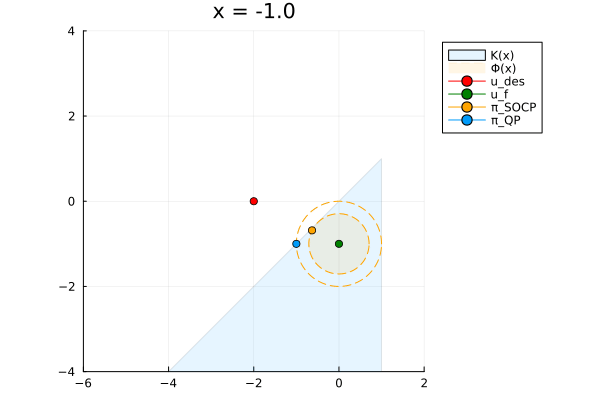

In [208]:
# Example 1
LC = LipschitzControllers

umax = 10.0
udes = x ->[-2.0, 0.0]
A = x->[[1;; 0.]; [-1;; -x]]
B = x -> [1., -1-x]
uf = x-> [1 -  x^2 , 1.0 + 2*x]
LipschitzControllers.animate(udes, A, B, uf, umax)

[ Info: Saved animation to /home/dasc-lab/Desktop/Lipscthiz_controller/tmp.gif


Plots.AnimatedGif("/home/dasc-lab/Desktop/Lipscthiz_controller/tmp.gif")
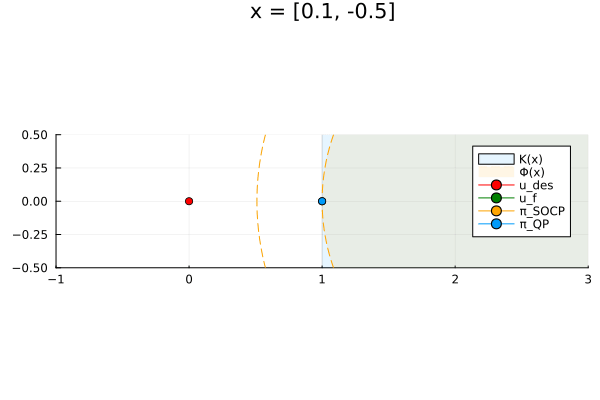

In [209]:
# Example 2 (Simplified Robinson's counterexample)
umax = 100.0
udes = x-> [0.0, 0.0]
A = x -> [[-1;; 0]; [-1;; -x[1]]]
B = x -> [-1, -1-x[2]]

m = 2
uf = x -> [m + abs(x[2]), 0]

@gif for tau in range(-1/2, 1/2, length=60)
    x = [0.1, tau]
     LipschitzControllers.animate_helper(udes(x), A(x), B(x), uf(x), umax)
    title!("x = $(round.(x, digits =3))")
    ylims!(-0.5, 0.5)
    xlims!(-1,3)
end
